# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)

## Dataset and imports


In [1]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec

from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error


from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [2]:
train = pd.read_csv('data/train_per_hour.csv')
train.drop(['Date'], axis=1, inplace=True)
train.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.222889,0.229000,234.643889,18.1,0.0,0.527778,16.861111
1,3.632200,0.080033,234.580167,15.6,0.0,6.716667,16.866667


### Dataset preprocessing

In [3]:
# scale the data, split it into sequences and shuffle the sequences to imitate i.i.d
def real_data_loading(data: np.array, seq_len):
    """Load and preprocess real-world datasets.
    Args:
      - data_name: Numpy array with the values from a a Dataset
      - seq_len: sequence length
    Returns:
      - data: preprocessed data.
    """
    # Flip the data to make chronological data
    ori_data = data[::-1]
    # Normalize the data
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data

In [4]:
seq_len=48
data = real_data_loading(data=train, seq_len=seq_len)
print(len(data), data[0].shape)

7170 (48, 7)


## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.


In [5]:

n_seq = 7
hidden_dim = 24
gamma=1 # Used for discriminator loss

noise_dim = 32 # Used by generator as a starter dimension
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
train_steps = 5000

gan_args = ModelParameters(batch_size=batch_size,lr=learning_rate,noise_dim=noise_dim,layers_dim=dim)

## Training the TimeGAN synthetizer

In [6]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(data, train_steps=train_steps)
synth.save('synthesizer_stock.pkl')

Joint networks training:  41%|████      | 2059/5000 [3:42:11<6:33:32,  8.03s/it]     

### The generated synthetic stock data

In [ ]:
synth = TimeGAN.load('synthesizer_stock.pkl')
synth_data = synth.sample(len(data))
synth_data = synth_data[:len(data)]
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 225/225 [01:26<00:00,  2.59it/s]

(7170, 48, 7)


In [ ]:
assert(len(data)==len(synth_data))

## Visualize the generated data

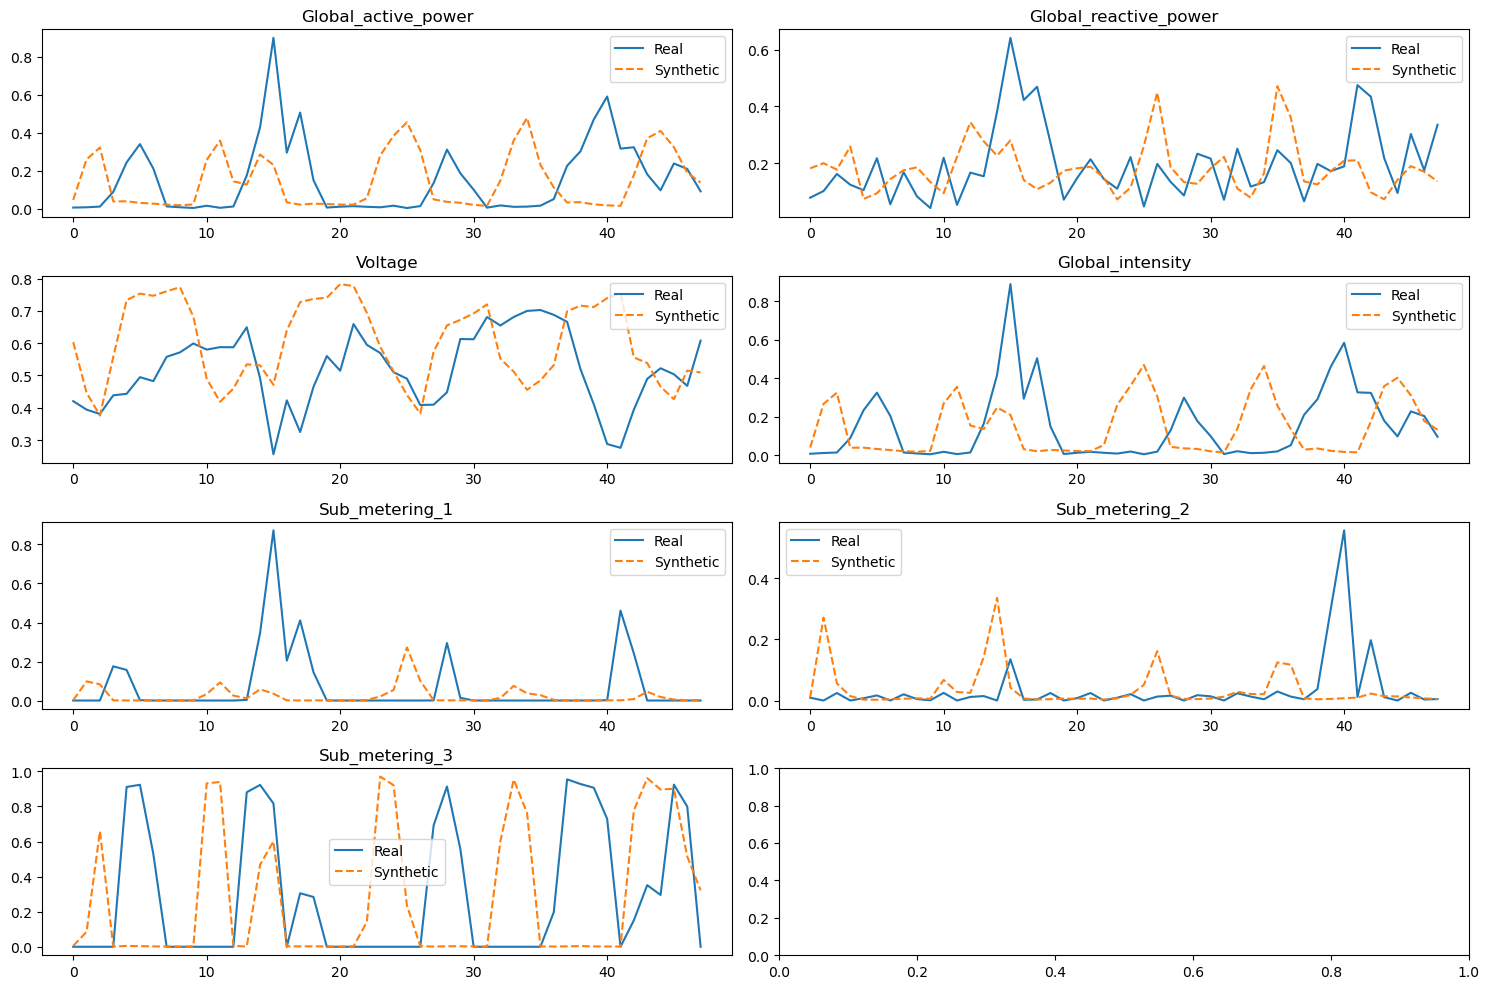

In [ ]:
#Reshaping the data
cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(data))

for j, col in enumerate(cols):
  
    df = pd.DataFrame({'Real': data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', 
            style=['-', '--'])
    
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)
- Visually

In [ ]:
sample_size = 250
idx = np.random.permutation(len(data))[:sample_size]

real_sample = np.asarray(data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

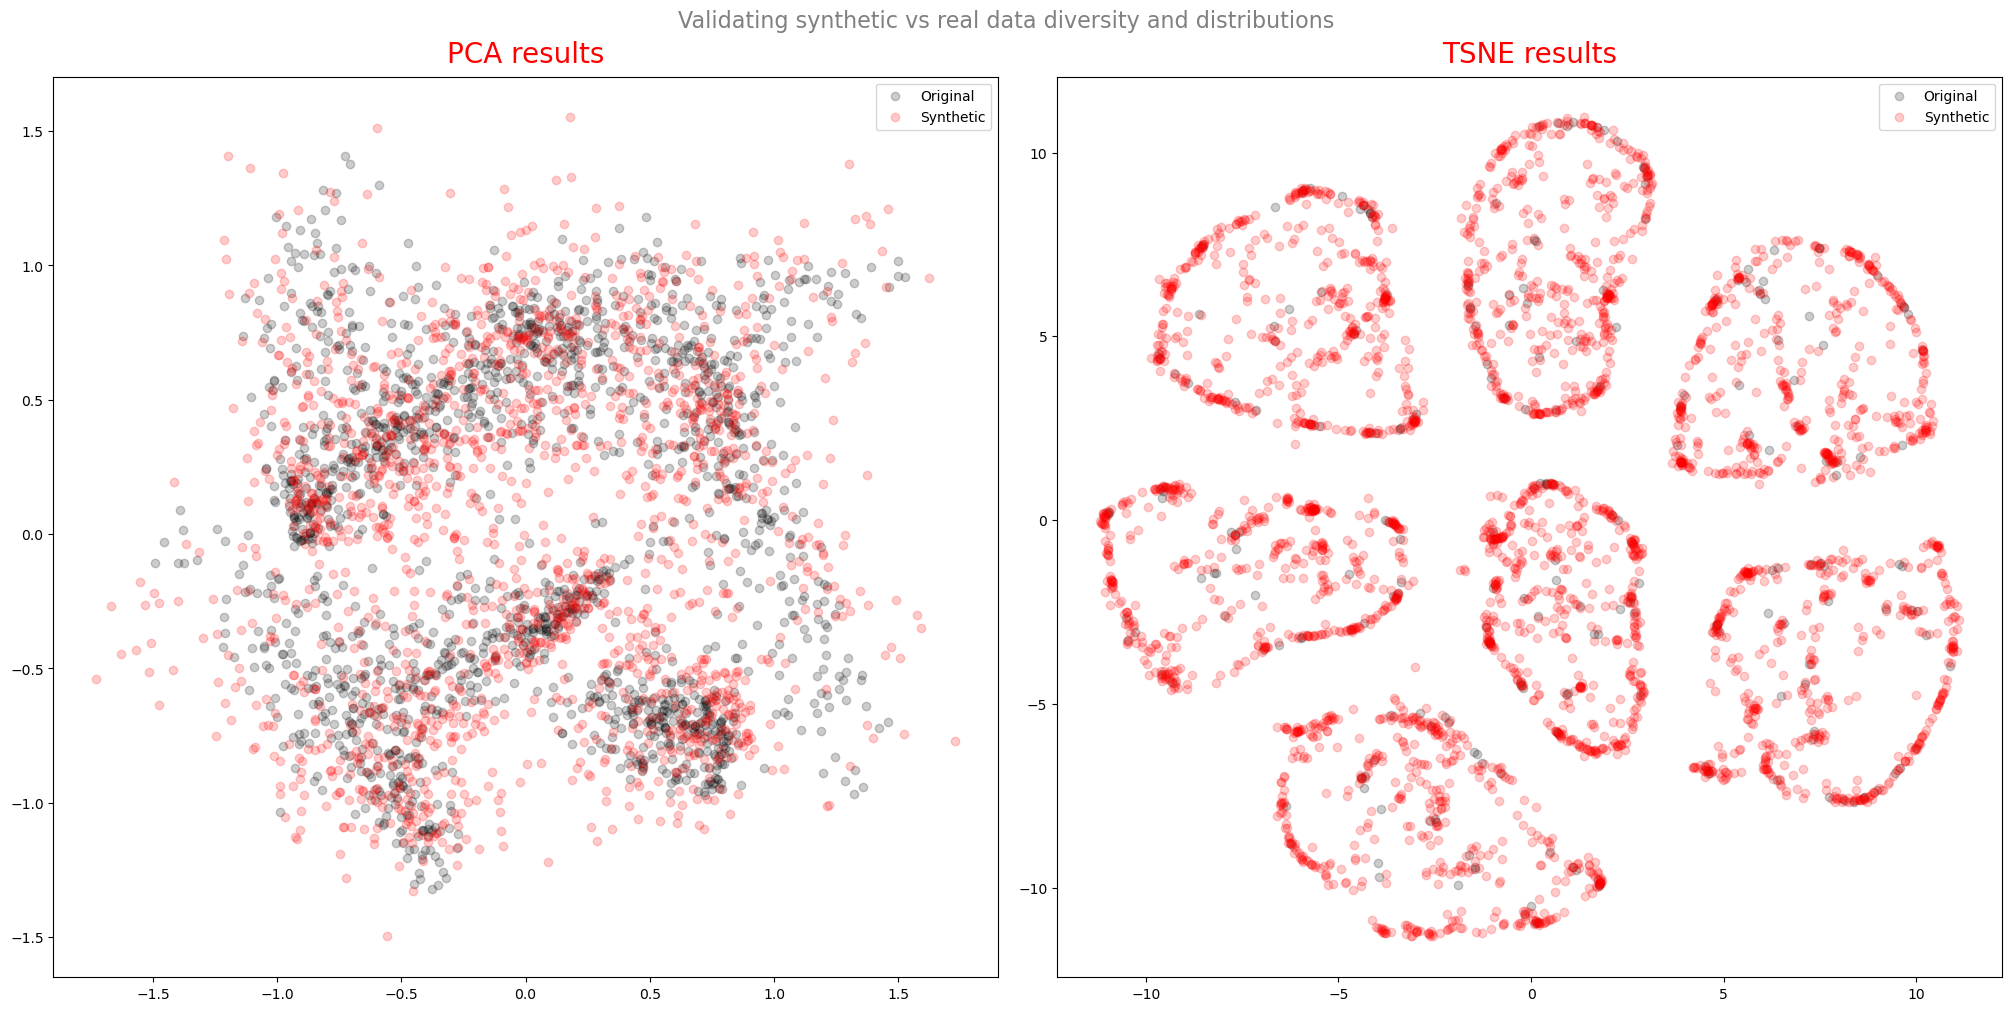

In [ ]:
#The scatter plots for PCA and TSNE methods
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

* We notice that, in the PCA plot, we have an overalap between the synthetic and the real data. By comparing the PCA plot of the synthetic data generated by TimeGAN with the PCA plot of the real data, we can evaluate how well TimeGAN has captured the important features and patterns in the data.
* t-SNE plot serves to understand the local structure of the data. We have a good overlap of the tSNE plot of the two datasets . 
==> Promissing results

- Further analysis

In [ ]:
# reconstruct a dataframe from synthetic data
synth_df = pd.DataFrame(synth_data.reshape(-1, 7), columns=cols)
# Reverse the normalization
synth_df = synth_df * (train.max() - train.min()) + train.min()
synth_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0.849330,0.135731,236.118934,3.571750,0.281360,1.627498,0.102709
1,2.868631,0.162625,234.960139,12.326840,5.472253,11.838077,15.603933
2,2.367117,0.250549,235.694828,10.453853,3.991692,4.102578,17.230167
3,0.625589,0.111362,239.705205,2.756324,0.171014,0.299209,1.897363
4,0.428844,0.047793,244.122234,1.737300,0.030158,0.051626,0.263272


In [ ]:
train.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,7218.000000,7218.000000,7218.000000,7218.000000,7218.000000,7218.000000,7218.000000
mean,1.089614,0.122532,239.038995,4.665609,1.217271,1.638770,5.522177
std,0.989137,0.066215,3.313865,4.163135,3.723583,4.766784,7.126821
min,0.138733,0.021033,225.834500,0.626667,0.000000,0.000000,0.000000
25%,0.290958,0.078167,236.685042,1.300000,0.000000,0.000000,0.000000
50%,0.721650,0.104167,239.498667,3.125000,0.000000,0.333333,0.000000
75%,1.631950,0.146558,241.376167,6.905833,0.000000,0.733333,12.283333
max,6.363867,0.575267,250.342500,27.703333,48.366667,40.050000,18.783333


In [ ]:
synth_df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,344160.000000,344160.000000,344160.000000,344160.000000,344160.000000,344160.000000,344160.000000
mean,1.127413,0.127807,239.660442,4.840584,1.230162,1.330295,5.642112
std,0.938215,0.058432,3.283760,3.954010,2.248778,2.420575,7.411206
min,0.211527,0.039135,230.190963,0.955324,0.012743,0.029234,0.011360
25%,0.322577,0.082477,236.853901,1.443835,0.044821,0.218888,0.034569
50%,0.634252,0.117575,239.952355,2.803555,0.164282,0.460161,0.118820
75%,1.964481,0.155135,242.618556,8.321440,1.450062,1.313268,14.682816
max,3.907436,0.385828,246.916879,16.876284,32.370044,27.050461,18.368037


- Train with real and synthetic data to further compare the synthetic data quality

In [ ]:

#Implementation of a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=7,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [ ]:
#Prepare the dataset for the regression model
stock_data=np.asarray(data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Synthetic y train: {}'.format(y_synth_train.shape))

print('Real X train: {}'.format(X_stock_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (5377, 47, 7)
Synthetic y train: (5377, 7)
Real X train: (5377, 47, 7)
Real y train: (5377, 7)
Real X test: (1793, 47, 7)
Real y test: (1793, 7)


In [ ]:
#Training the model with the real train data
ts_real = RNN_regression(12)
ts_synth= RNN_regression(12)


In [ ]:

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,verbose=0)
synth_train= ts_synth.fit(x=X_synth_train,
                            y=y_synth_train,
                            validation_data=(X_stock_test, y_stock_test),
                            epochs=200,
                            batch_size=128,verbose=0)

In [ ]:
#Summarize the metrics here as a pandas dataframe
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

57/57 [==============================] - 0s 3ms/step


,r2,MAE,MRLE
Real,0.330525,0.069455,0.012105
Synthetic,0.129919,0.094719,0.016827
